In [1]:
 from google.colab import drive
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install kmodes

In [3]:
cd '/content/drive/My Drive/Colab Notebooks/dl/data' 

/content/drive/.shortcut-targets-by-id/1ZyNJXaTInYA2YPBLOAFnql__PhYO31aJ/data


In [72]:
import numpy as np
import pandas as pd
import pickle as pkl
from tabulate import tabulate
import os
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
from kmodes.kprototypes import KPrototypes
from joblib import dump, load

### Initiating Feature Analysis and Selection for all Students who voluntarily reported having taken a course or a specialization

In [5]:
# Loading Students data set from a pickle file - All features are ready for analysis and selection!
df_converted_students = pd.read_pickle("./converted_students01272021.pkl")

In [6]:
import pickle as pkl
def Load_Dicts(pkl_filename):
  All_Dicts = pkl.load( open (pkl_filename, "rb"))
  Dict_Opt= All_Dicts[0]
  Events_Dict= All_Dicts[1]
  Education_Dict= All_Dicts[2]
  Jobs_Dict= All_Dicts[3]
  Countries_Dict = All_Dicts[4]
  Companies_Dict = All_Dicts[5]
  First_Pages_Dict = All_Dicts[6]
  Last_Pages_Dict = All_Dicts[7]
  Courses_Dict= All_Dicts[8]
  return Dict_Opt, Events_Dict, Education_Dict, Jobs_Dict, Countries_Dict, Companies_Dict, First_Pages_Dict, Last_Pages_Dict, Courses_Dict

In [7]:
# Loading all dictionaries (categorical features) from a pickle file
Dict_Opt, Events_Dict, Education_Dict, Jobs_Dict, Countries_Dict, Companies_Dict, First_Pages_Dict, Last_Pages_Dict, Courses_Dict= Load_Dicts("all_dictionaries.pkl")

In [8]:
binary_columns = ['Opted out of email: Events and Community', 'Opted out of email: Program Announcements', 'Opted out of email: The Batch', 'Unsubscribed from all email', 'AI For Everyone', 'Deep Learning Specialization', 'Natural Language Processing Specialization', 'AI for Medicine Specialization', 'TensorFlow Developer Professional Certificate','TensorFlow: Data and Deployment Specialization']
numeric_columns = ['Number of Pageviews','Average Pageviews','Number of Sessions','Marketing emails opened', 'Marketing emails delivered','Marketing emails clicked', 'Total Education Effort']
timestamp_columns = ['Became a Lead Date', 'Became a Subscriber Date', 'First Conversion Date', 'First marketing email click date', 'First marketing email open date', 'First marketing email send date', 'Last marketing email click date', 'Last marketing email open date', 'Last marketing email send date','Last Registered Event Date']
categorical_columns = ['First Page Seen Path', 'Last Page Seen Path', 'Last Registered Event','Last marketing email name','Highest level of completed education', 'Job Title or Function', 'IP Country', 'Associated Company ID']

In [9]:
def drop_crr(df,tol=0.8):
	crr = df_std.corr().abs()
	keep_columns = df.columns.to_list()
	keep_dict = {clm:True for clm in keep_columns}
	for i in range(0,len(keep_columns)-1):
		# Loop over all columns to the right of the current one
	    	for j in range(i+1,len(keep_columns)):
	    		# If the absolute correlation between the current two columns is greater than or equal to 0.8...
	    		if crr[keep_columns[i]].loc[keep_columns[j]] >= tol:
	    			# If we haven't already told the keep_columns list to drop column j...
	    			if keep_dict[keep_columns[j]] == True:
	    				# Drop column j
	    				keep_dict[keep_columns[j]] = False
	selected_columns = [clm for clm in keep_dict if keep_dict[clm] == True]
	return selected_columns

In [10]:
df_std = df_converted_students[numeric_columns]
selected = drop_crr(df_std)
all = df_std.columns
drop = list(set(all)^set(selected))

In [11]:
drop

['Marketing emails delivered', 'Number of Sessions']

In [12]:
df_converted_students = df_converted_students.drop(columns=drop)

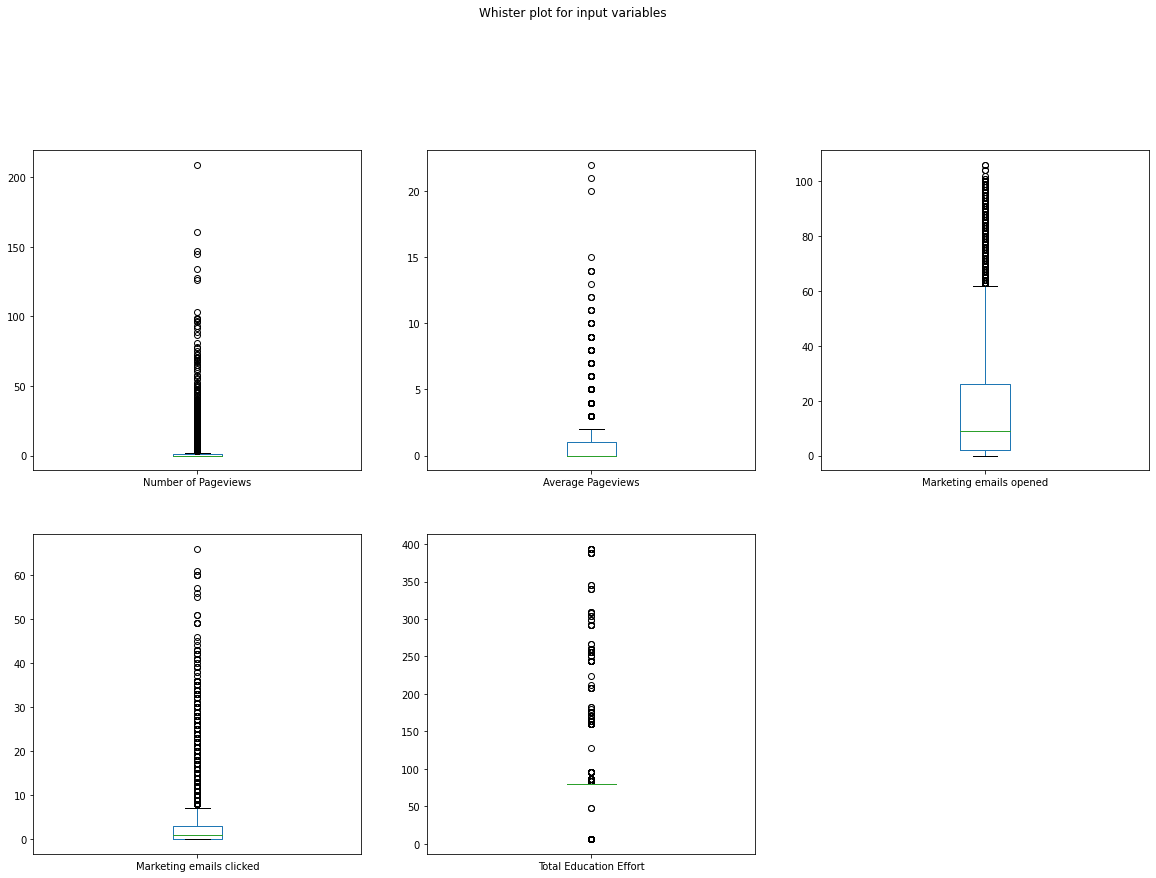

In [13]:
# Whiskerplots
c = 'black'
df_std[selected].plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(20,20),
                                        title='Whister plot for input variables')
plt.savefig('Numeric Features')
plt.show()

## 1. User Journeys of Group of Interest 1 - Positive Conversion with Information about Courses/Specializations Taken - High Engagement Level - Unsupervised Learning - Clustering

### We will focus our analysis on user journeys of converted students (Contact IDs who voluntarily informed having taken courses or specializations) over the complete period of time provided in the hub_spot_export.csv data set

In [14]:
# Excluding all timestamp_colummns from this analysis 
df_base = df_converted_students.drop(columns=timestamp_columns).copy()
df_base = df_base.drop(columns='Contact ID')

### The standard k-means algorithm isn't directly applicable to categorical data, for various reasons. The sample space for categorical data is discrete, and doesn't have a natural origin. A Euclidean distance function on such a space isn't really meaningful. As someone put it, "The fact a snake possesses neither wheels nor legs allows us to say nothing about the relative value of wheels and legs."
### There's a variation of k-means known as k-modes, introduced in this paper by Zhexue Huang, which is suitable for categorical data. Note that the solutions you get are sensitive to initial conditions, as discussed here (PDF), for instance.
### Huang's paper also has a section on "k-prototypes" which applies to data with a mix of categorical and numeric features. It uses a distance measure which mixes the Hamming distance for categorical features and the Euclidean distance for numeric features.
### References:
### 1- k-modes clustering ( Chaturvedi, A., Green, P.E. et al (2001) Journal of Classification 18, 35-55 ) by implementing algorithm as decribed in Huang, Z. ( 1998 ) Data Mining and Knowledge Discovery 2, 283-304
### 2- "K-Mode Clustering | Solved Example | Implementation" https://www.youtube.com/watch?v=EVl2ejcsTfg
### 3-"K-ModesClustering" https://medium.com/@shailja.nitp2013/k-modesclustering-ef6d9ef06449 
### 4- Clustering Algorithm for mixed datatypes - K-Prototypes https://www.youtube.com/watch?v=8eATPLDJ0NQ
### 5- https://pypi.org/project/kmodes/ and https://github.com/nicodv/kmodes

In [15]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13184 entries, 0 to 13183
Data columns (total 23 columns):
 #   Column                                          Non-Null Count  Dtype
---  ------                                          --------------  -----
 0   Last marketing email name                       13184 non-null  int64
 1   Average Pageviews                               13184 non-null  int64
 2   Number of Pageviews                             13184 non-null  int64
 3   Marketing emails opened                         13184 non-null  int64
 4   Marketing emails clicked                        13184 non-null  int64
 5   Opted out of email: Events and Community        13184 non-null  int64
 6   Opted out of email: Program Announcements       13184 non-null  int64
 7   Opted out of email: The Batch                   13184 non-null  int64
 8   Unsubscribed from all email                     13184 non-null  int64
 9   Last Registered Event                           13184 non-nul

In [16]:
Data= df_base.values.astype(int)

In [17]:
# KPrototypes algorithm needs to know which features/columns are categorical
cat=[0,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]

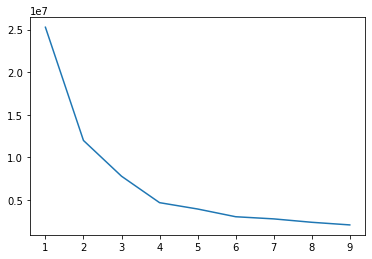

In [28]:
# Using The Elbow Method to identify the optimal number of clusters
cost = []
for num_clusters in list(range(1,10)):
  kproto = KPrototypes(n_clusters=num_clusters, n_init = 10, max_iter=10, random_state=42, verbose=0)
  kproto.fit_predict(Data,categorical=cat)
  cost.append(kproto.cost_)
y = np.array([i for i in range(1,10,1)])
plt.plot(y,cost)

In [29]:
kproto = KPrototypes(n_clusters=4, n_init = 10, max_iter=10, random_state=42, verbose=0)
clusters = kproto.fit_predict(Data,categorical=cat)

In [82]:
# print(kproto.cluster_centroids_)

In [31]:
# Assigning Cluster numbers to each Contact ID/entry
cluster_dict=[]
for c in clusters:
  cluster_dict.append(c)
df_base['Cluster']=cluster_dict

In [36]:
df_base[df_base['Cluster']==0].head(20)

,Last marketing email name,Average Pageviews,Number of Pageviews,Marketing emails opened,Marketing emails clicked,Opted out of email: Events and Community,Opted out of email: Program Announcements,Opted out of email: The Batch,Unsubscribed from all email,Last Registered Event,Highest level of completed education,Job Title or Function,IP Country,Associated Company ID,First Page Seen Path,Last Page Seen Path,AI For Everyone,Deep Learning Specialization,Natural Language Processing Specialization,AI for Medicine Specialization,TensorFlow Developer Professional Certificate,TensorFlow: Data and Deployment Specialization,Total Education Effort,Cluster
2,0,0,0,0,0,0,0,0,0,8,0,0,6,0,1,1,0,1,0,0,0,0,80,0
3,0,0,0,0,0,0,0,0,0,8,0,5,6,202,1,1,0,1,0,0,0,0,80,0
5,0,0,0,0,0,0,0,0,0,8,0,6,6,220,1,1,0,1,0,0,0,0,80,0
6,0,0,0,0,0,0,0,0,0,8,0,7,6,0,1,1,0,1,0,0,0,0,80,0
8,9,2,2,2,0,0,0,0,0,0,3,8,13,0,1,1,0,1,0,0,0,0,80,0
10,9,1,1,1,0,0,0,0,0,0,2,12,0,0,1,1,1,1,0,0,0,0,86,0
11,0,0,0,0,0,0,0,0,0,8,0,4,6,0,1,1,0,1,0,0,0,0,80,0
12,0,0,0,0,0,0,0,0,0,11,0,1,6,279,1,1,0,1,0,0,0,0,80,0
13,0,0,0,0,0,0,0,0,0,10,0,6,6,0,1,1,0,1,0,0,0,0,80,0
15,0,0,0,0,0,0,0,0,0,11,0,11,6,0,1,1,0,1,0,0,0,0,80,0


In [83]:
df_base[df_base['Cluster']==1].head(20)

,Last marketing email name,Average Pageviews,Number of Pageviews,Marketing emails opened,Marketing emails clicked,Opted out of email: Events and Community,Opted out of email: Program Announcements,Opted out of email: The Batch,Unsubscribed from all email,Last Registered Event,Highest level of completed education,Job Title or Function,IP Country,Associated Company ID,First Page Seen Path,Last Page Seen Path,AI For Everyone,Deep Learning Specialization,Natural Language Processing Specialization,AI for Medicine Specialization,TensorFlow Developer Professional Certificate,TensorFlow: Data and Deployment Specialization,Total Education Effort,Cluster
9,9,1,6,2,0,0,0,0,0,0,1,10,12,0,1,1,0,1,0,0,1,0,160,1
52,9,1,1,2,0,0,0,0,0,0,2,5,12,0,1,1,0,1,0,0,1,1,208,1
175,9,1,3,7,0,0,0,0,0,0,3,9,23,0,1,14,1,1,0,0,1,0,166,1
248,9,2,2,3,0,0,0,0,0,0,1,3,37,0,1,1,1,1,1,0,0,0,182,1
276,9,1,1,1,0,0,0,0,0,54,2,11,34,0,1,1,0,1,0,0,1,0,160,1
3554,25,2,2,8,0,0,0,0,1,0,2,3,15,4654,1,1,0,1,1,0,1,0,256,1
3569,9,1,2,7,2,0,0,0,0,0,2,7,29,0,1,1,0,1,1,0,1,0,256,1
3675,0,0,1,0,0,0,0,0,0,0,2,10,17,318,1,1,0,1,0,0,1,0,160,1
3735,0,0,0,0,0,0,0,0,0,0,3,6,1,4813,1,1,0,1,1,0,0,0,176,1
3749,9,0,0,7,0,0,0,0,0,0,3,3,1,0,1,1,0,1,0,0,1,0,160,1


In [84]:
df_base[df_base['Cluster']==2].head(20)

,Last marketing email name,Average Pageviews,Number of Pageviews,Marketing emails opened,Marketing emails clicked,Opted out of email: Events and Community,Opted out of email: Program Announcements,Opted out of email: The Batch,Unsubscribed from all email,Last Registered Event,Highest level of completed education,Job Title or Function,IP Country,Associated Company ID,First Page Seen Path,Last Page Seen Path,AI For Everyone,Deep Learning Specialization,Natural Language Processing Specialization,AI for Medicine Specialization,TensorFlow Developer Professional Certificate,TensorFlow: Data and Deployment Specialization,Total Education Effort,Cluster
0,4,2,2,0,0,0,0,0,0,0,1,2,13,118,1,1,1,0,0,0,0,0,6,2
1,0,0,0,0,0,0,0,0,0,0,2,3,43,0,1,1,1,0,0,0,0,0,6,2
4,0,0,0,0,0,0,0,0,0,8,0,6,6,0,1,1,1,0,0,0,0,0,6,2
7,9,0,1,2,0,0,0,0,0,0,2,2,12,0,1,1,1,0,0,0,0,0,6,2
14,0,0,0,0,0,0,0,0,0,8,0,5,6,0,1,1,1,0,0,0,0,0,6,2
16,9,2,6,3,1,0,0,0,0,0,1,8,45,0,1,1,1,0,0,0,0,0,6,2
17,9,1,1,1,0,0,0,0,0,0,2,14,17,149,1,1,1,0,0,0,0,0,6,2
18,0,0,0,0,0,0,0,0,0,8,0,7,6,0,1,1,1,0,0,0,0,0,6,2
19,0,0,0,0,0,0,0,0,0,8,0,9,6,0,1,1,1,0,0,0,0,0,6,2
21,0,0,0,0,0,0,0,0,0,10,0,6,6,0,1,1,1,0,0,0,0,0,6,2


In [85]:
df_base[df_base['Cluster']==3].head(20)

,Last marketing email name,Average Pageviews,Number of Pageviews,Marketing emails opened,Marketing emails clicked,Opted out of email: Events and Community,Opted out of email: Program Announcements,Opted out of email: The Batch,Unsubscribed from all email,Last Registered Event,Highest level of completed education,Job Title or Function,IP Country,Associated Company ID,First Page Seen Path,Last Page Seen Path,AI For Everyone,Deep Learning Specialization,Natural Language Processing Specialization,AI for Medicine Specialization,TensorFlow Developer Professional Certificate,TensorFlow: Data and Deployment Specialization,Total Education Effort,Cluster
1479,71,0,0,36,4,1,0,1,1,89,0,9,6,0,1,1,0,1,0,0,0,0,80,3
4029,41,1,1,44,6,0,0,0,1,89,0,3,18,2966,1,1,0,1,0,0,0,0,80,3
5468,9,1,5,35,4,0,0,0,0,89,0,0,12,0,1,65,0,1,0,0,0,0,80,3
5497,9,1,7,33,7,0,0,0,0,0,1,3,40,7120,1,22,0,1,0,0,0,0,80,3
5574,9,0,33,33,14,0,0,0,0,32,0,3,39,0,1,1,0,1,0,0,0,0,80,3
5936,9,0,0,36,0,0,0,0,0,181,0,0,1,7513,1,1,0,1,0,0,0,0,80,3
5947,9,2,6,36,18,0,0,0,0,59,0,4,54,0,1,65,0,1,0,0,0,0,80,3
5968,9,0,0,33,12,0,0,0,0,18,0,6,0,0,1,1,0,1,0,0,0,0,80,3
5983,9,3,9,39,3,0,0,0,0,89,0,8,12,0,1,1,0,1,0,0,0,0,80,3
6165,9,0,0,35,1,0,0,0,0,181,0,0,4,7700,1,1,0,1,0,0,0,0,80,3


In [89]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13184 entries, 0 to 13183
Data columns (total 24 columns):
 #   Column                                          Non-Null Count  Dtype
---  ------                                          --------------  -----
 0   Last marketing email name                       13184 non-null  int64
 1   Average Pageviews                               13184 non-null  int64
 2   Number of Pageviews                             13184 non-null  int64
 3   Marketing emails opened                         13184 non-null  int64
 4   Marketing emails clicked                        13184 non-null  int64
 5   Opted out of email: Events and Community        13184 non-null  int64
 6   Opted out of email: Program Announcements       13184 non-null  int64
 7   Opted out of email: The Batch                   13184 non-null  int64
 8   Unsubscribed from all email                     13184 non-null  int64
 9   Last Registered Event                           13184 non-nul

In [37]:
# Saving Group of Interest 1 - Positive Conversion with Information about Courses/Specializations Taken - High Engagement Level - clustering data set to pickle file - No changes in the Dictionaries
df_base.to_pickle("./converted_students_clustering_data_01282021.pkl")

In [39]:
# Saving Group of Interest 1 - Positive Conversion with Information about Courses/Specializations Taken - Clustering model to a joblib file
# Use model = load('filename.joblib') to load this model from a the joblib file
dump(kproto, "./converted_students_cluster_model.joblib") 

['./converted_students_cluster_model.joblib']

## 2. User Journeys of Group of Interest 1 - Positive Conversion with Information about Courses/Specializations Taken - High Engagement Level - Using Supervised Learning to get Feature Ranks considering 'Total Education Effort' as target feature

### Considering Customer Engagement is this particular use case can be defined by three specific measures/features (target features 'Total Education Effort', 'Number of Page Views' and/or 'Marketing emails clicked') we will initially use Random Forests to get feature ranks for 'Total Education Effort'

### 2a. Featuring Ranking to build a 'Total Education Effort' Estimation Model

In [56]:
# Saving Converted Students clustering data set to pickle file - No changes in the Dictionaries
df_base = pd.read_pickle("./converted_students_clustering_data_01282021.pkl")

In [58]:
y_train = df_base['Total Education Effort'].values.astype(int)

In [61]:
# Dropping 'Total Education Effort' (y_train), 'Cluster' (not relevant) and all course/specialization features ('Total Education Effort' is a linear combination of them)
df_tef = df_base.drop(columns=['Total Education Effort','AI For Everyone','AI For Everyone','Deep Learning Specialization','Natural Language Processing Specialization','AI for Medicine Specialization','TensorFlow Developer Professional Certificate', 'TensorFlow: Data and Deployment Specialization', 'Cluster'] ).copy()

In [62]:
X_train= df_tef.values.astype(int)

In [69]:
#Use Random Forest to get feature ranks/importances for each feature
# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesClassifier(n_estimators=20,random_state=42)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


Feature ranking:
1. feature 3 - Last marketing email name (0.198095)
2. feature 12 - Average Pageviews (0.155130)
3. feature 9 - Number of Pageviews (0.128376)
4. feature 11 - Marketing emails opened (0.120860)
5. feature 13 - Marketing emails clicked (0.097182)
6. feature 4 - Opted out of email: Events and Community (0.088718)
7. feature 0 - Opted out of email: Program Announcements (0.070674)
8. feature 2 - Opted out of email: The Batch (0.053513)
9. feature 1 - Unsubscribed from all email (0.041914)
10. feature 10 - Last Registered Event (0.023804)
11. feature 15 - Highest level of completed education (0.009242)
12. feature 8 - Job Title or Function (0.004772)
13. feature 14 - IP Country (0.004650)
14. feature 7 - Associated Company ID (0.001389)
15. feature 5 - First Page Seen Path (0.001118)
16. feature 6 - Last Page Seen Path (0.000563)


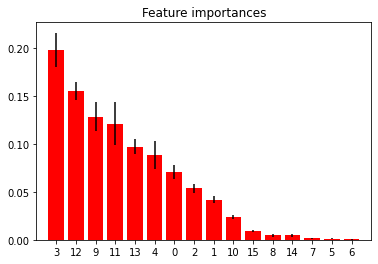

In [70]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f],df_tef.columns[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [74]:
cut_off = 0.05
keep_columns = df_tef.columns.to_list()
keep_dict = {}
keep_dict = {clm:True for clm in keep_columns}
for i in range(0,len(keep_columns)-1):
    # Loop over all columns to the right of the current one
    for j in range(i+1,len(keep_columns)):
        # If the importance of the feature calculated based on impurity is greater than or equal to 0.01
        if importances[indices[i]] <= cut_off:
            # If we haven't already told the keep_columns list to drop column j...
            if keep_dict[keep_columns[j]] == True:
                # Drop column j
                keep_dict[keep_columns[j]] = False
selected_columns = [clm for clm in keep_dict if keep_dict[clm] == True]
df_tef_opt= df_tef[selected_columns].copy()

In [109]:
df_tef_opt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13184 entries, 0 to 13183
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   Last marketing email name                  13184 non-null  int64
 1   Average Pageviews                          13184 non-null  int64
 2   Number of Pageviews                        13184 non-null  int64
 3   Marketing emails opened                    13184 non-null  int64
 4   Marketing emails clicked                   13184 non-null  int64
 5   Opted out of email: Events and Community   13184 non-null  int64
 6   Opted out of email: Program Announcements  13184 non-null  int64
 7   Opted out of email: The Batch              13184 non-null  int64
 8   Unsubscribed from all email                13184 non-null  int64
dtypes: int64(9)
memory usage: 927.1 KB


## 3 - Group of Interest 2 - Positive Conversion but No Information about Courses/Specializations Taken - Medium Engagement Level - Unsupervised Learning - Clustering

### We will focus our analysis on user journeys of converted contact IDs with a Positive Conversion but No Information about Courses/Specializations Taken. We work on complete period of time provided in the hub_spot_export.csv data set

In [98]:
# Loading Converted Group of Interest 2 data set from a pickle file 
df_converted= pd.read_pickle("./converted_01282021.pkl")

In [99]:
# Loading all dictionaries (categorical features) from a pickle file
Dict_Opt, Events_Dict, Education_Dict, Jobs_Dict, Countries_Dict, Companies_Dict, First_Pages_Dict, Last_Pages_Dict, Courses_Dict= Load_Dicts("all_dictionaries.pkl")

In [100]:
binary_columns = ['Opted out of email: Events and Community', 'Opted out of email: Program Announcements', 'Opted out of email: The Batch', 'Unsubscribed from all email', 'AI For Everyone', 'Deep Learning Specialization', 'Natural Language Processing Specialization', 'AI for Medicine Specialization', 'TensorFlow Developer Professional Certificate','TensorFlow: Data and Deployment Specialization']
numeric_columns = ['Number of Pageviews','Average Pageviews','Number of Sessions','Marketing emails opened', 'Marketing emails delivered','Marketing emails clicked', 'Total Education Effort']
timestamp_columns = ['Became a Lead Date', 'Became a Subscriber Date', 'First Conversion Date', 'First marketing email click date', 'First marketing email open date', 'First marketing email send date', 'Last marketing email click date', 'Last marketing email open date', 'Last marketing email send date','Last Registered Event Date']
categorical_columns = ['First Page Seen Path', 'Last Page Seen Path', 'Last Registered Event','Last marketing email name','Highest level of completed education', 'Job Title or Function', 'IP Country', 'Associated Company ID']

In [94]:
drop = ['Marketing emails delivered', 'Number of Sessions']

In [103]:
# Excluding all timestamp_colummns, numerical features with high correlation and Contact ID from this analysis 
df_base = df_converted.drop(columns=timestamp_columns).copy()
df_base = df_base.drop(columns=['Contact ID','Which of the following online courses have you taken from deeplearning.ai?'])
df_base = df_base.drop(columns=drop)

In [106]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86499 entries, 0 to 336926
Data columns (total 16 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   Last marketing email name                  86499 non-null  int64
 1   Average Pageviews                          86499 non-null  int64
 2   Number of Pageviews                        86499 non-null  int64
 3   Marketing emails opened                    86499 non-null  int64
 4   Marketing emails clicked                   86499 non-null  int64
 5   Opted out of email: Events and Community   86499 non-null  int64
 6   Opted out of email: Program Announcements  86499 non-null  int64
 7   Opted out of email: The Batch              86499 non-null  int64
 8   Unsubscribed from all email                86499 non-null  int64
 9   Last Registered Event                      86499 non-null  int64
 10  Highest level of completed education       86

In [104]:
Data= df_base.values.astype(int)

In [110]:
cat=[0,5,6,7,8,9,10,11,12,13,14,15]

In [ ]:
# Using The Elbow Method to identify the optimal number of clusters
cost = []
for num_clusters in list(range(1,10)):
  kproto = KPrototypes(n_clusters=num_clusters, n_init = 10, max_iter=10, random_state=42, verbose=0)
  kproto.fit_predict(Data,categorical=cat)
  cost.append(kproto.cost_)
y = np.array([i for i in range(1,10,1)])
plt.plot(y,cost)

In [ ]:
kproto = KPrototypes(n_clusters=4, n_init = 10, max_iter=10, random_state=42, verbose=0)
clusters = kproto.fit_predict(Data,categorical=cat)

In [ ]:
# Assigning Cluster numbers to each Contact ID/entry
cluster_dict=[]
for c in clusters:
  cluster_dict.append(c)
df_base['Cluster']=cluster_dict

In [ ]:
df_base[df_base['Cluster']==0].head(20)

In [ ]:
# Saving Group of Interest 2 - Positive Conversion but No Information about Courses/Specializations Taken - Medium Engagement Level clustering data set to pickle file - No changes in the Dictionaries
df_base.to_pickle("./converted_clustering_data_01282021.pkl")

In [ ]:
# Saving Group of Interest 2 - Positive Conversion but No Information about Courses/Specializations Taken -  Clustering model to a joblib file
# Use model = load('filename.joblib') to load this model from a the joblib file
dump(kproto, "./converted_cluster_model.joblib") 